### Group Details

Group ID - 59

| Sl. No | Name  | BITS ID  | Contribution  |
|--------|-------|---------|---------------|
| 1      |   Rajit Roy    |    2023ac05605     |      100%         |
| 2      |       |         |     100%          |
| 3      |       |         |     100%          |
| 4      |       |         |     100%          |
| 5      |       |         |     100%          |

___

### Assignment 2 - Problem Statement 10

##### Question: Content Based Recommender System

___

### Data Used as Source

Data was picked from the BBC News Site.
Five Diverse topics were selected with each having multiple articles (8-16) in them.

Topics Were:

| Topic       | Number of Articles |
|------------|-------------------|
| 🖼️ **Arts**         | 10  |
| 💼 **Business**     | 15  |
| 🚀 **Innovation**   | 11  |
| 🖥️ **Technology**   | 17  |
| 🌍 **Travel**       | 7   |
| **Total**    | **60**



These were PDFs. 
For a full list of articles, refer to appendix below (At the end, below the Summary)

Public Link - https://drive.google.com/drive/folders/1w-0v7dazqmaeCaucZDrJgjm4m74iGyVS?usp=sharing

---

### Methodology: Step-by-Step Implementation 

##### 1. Document Processing  
- Extracted text from **60 BBC news articles** (Innovation, Arts, Technology, Business, Travel).  
- Applied **tokenization, stopword removal, stemming, and normalization**.  

##### 2. Indexing and TF-IDF Computation  
- Built an **inverted index** mapping terms to documents.  
- Computed **TF-IDF weights** for term significance and length normalization.  

##### 3. Query Evaluation and Similarity Computation  
- Designed **diverse test queries** mapped to relevant categories.  
- Ranked documents using **Cosine Similarity** between **TF-IDF vectors**.  

##### 4. Precision-Recall Evaluation  
- Measured **Precision, Recall, F1-Score, MAP, and R-Precision**.  
- Generated **Precision-Recall curves, Precision@k, and Interpolated Precision curves**.  

##### 5. Personalized Recommendations  
- Created **user profiles** with **interest-based queries**.  
- Retrieved documents using **TF-IDF similarity with profile-based reranking**.  

##### 6. Evaluation of Personalized Recommendations  
- Measured **category precision** and **term-based relevance matching**.  

___

### 1. Data Loading and Preprocessing

##### Imports

In [86]:
# %pip install PyPDF2 beautifulsoup4 nltk scikit-learn matplotlib seaborn

In [87]:
import math
import os
import re
from collections import Counter
from difflib import get_close_matches
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import logging
import PyPDF2

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/rajitroy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajitroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rajitroy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

##### Loading Documents

In [88]:
def extract_text_from_file(file_path):
    """
    Extract text from HTML, PDF, or TXT files.

    Args:
        file_path (str): Path to the file.

    Returns:
        str: Cleaned and extracted text content.
    """
    print("Extracting text from file:", file_path)
    try:
        # Check file type and handle accordingly
        if file_path.endswith('.html'):
            # Read HTML content
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
            # Parse HTML to extract clean text
            soup = BeautifulSoup(content, 'html.parser')
            text = soup.get_text(separator=' ', strip=True)

        elif file_path.endswith('.pdf'):
            # PDF parsing using PyPDF2

            with open(file_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                text = ""
                # Extract text page by page
                for page in pdf_reader.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + " "

        else:  # For TXT files
            # Directly read text file
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                text = file.read()

        # Remove extra whitespace and clean text
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    except Exception as e:
        # Print error message clearly
        print(f"Error extracting text from {file_path}: {e}")
        return ""

In [89]:
def load_documents(base_dir):
    """
    Load all documents from the specified directory structure

    Args:
        base_dir (str): Base directory containing subdirectories for categories

    Returns:
        dict: Dictionary with document IDs as keys and document info as values
    """
    documents = {}
    doc_id = 0

    # Create dictionary to store document paths
    doc_paths = {}

    # Walk through the directory structure
    for root, _, files in os.walk(base_dir):
        category = os.path.basename(root)

        for file in files:
            # Only process HTML, PDF, and text files
            if file.endswith(('.html', '.txt', '.csv', '.pdf')):
                file_path = os.path.join(root, file)

                # Extract text using our universal extractor for all file types
                text = extract_text_from_file(file_path)

                # Skip if no text was extracted
                if not text:
                    continue

                # Store document info
                doc_name = f"{category}/{file}"
                documents[doc_id] = {
                    'id': doc_id,
                    'name': doc_name,
                    'category': category,
                    'path': file_path,
                    'text': text,
                    'tokens': None,  # Will be populated during preprocessing
                    'term_freq': None,  # Will be populated during TF-IDF calculation
                }
                doc_paths[doc_id] = file_path
                doc_id += 1

    print(f"Loaded {len(documents)} documents from {base_dir}")
    return documents, doc_paths

##### Text Preprocessing

In [90]:
def preprocess_text(text):
    """
    Preprocess text: tokenize, remove stopwords, punctuation, and stem

    Args:
        text (str): Input text

    Returns:
        list: List of preprocessed tokens
    """
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove punctuation and non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [91]:
def preprocess_documents(documents):
    """
    Preprocess all documents in the collection

    Args:
        documents (dict): Dictionary of documents

    Returns:
        dict: Updated dictionary with preprocessed tokens
    """
    for doc_id, doc in documents.items():
        doc['tokens'] = preprocess_text(doc['text'])

    return documents


---

### 2. Indexing and Representation

##### Building the Inverted Index

In [92]:
def build_inverted_index(documents):
    """
    Build an inverted index mapping terms to documents

    Args:
        documents (dict): Dictionary of documents

    Returns:
        dict: Inverted index mapping terms to document IDs
    """
    inverted_index = defaultdict(list)

    for doc_id, doc in documents.items():
        # Get unique terms in the document
        unique_terms = set(doc['tokens'])

        # Add document to the posting list of each term
        for term in unique_terms:
            inverted_index[term].append(doc_id)

    return dict(inverted_index)

In [93]:
def display_inverted_index(inverted_index, top_n=10):
    """
    Display the inverted index (sorted)

    Args:
        inverted_index (dict): Inverted index mapping terms to document IDs
        top_n (int): Number of terms to display

    Returns:
        None
    """
    # Sort terms by their frequency (number of documents)
    sorted_terms = sorted(inverted_index.items(),
                          key=lambda x: len(x[1]),
                          reverse=True)

    print(f"Top {top_n} terms in the inverted index:")
    print("=" * 50)
    print("{:<20} {:<10} {:<20}".format("Term", "Doc Count", "Documents"))
    print("-" * 50)

    for term, doc_ids in sorted_terms[:top_n]:
        print("{:<20} {:<10} {:<20}".format(
            term, len(doc_ids), str(doc_ids[:5]) + "..." if len(doc_ids) > 5 else str(doc_ids)
        ))

##### Computing TF-IDF Scores

In [94]:
def calculate_term_frequencies(documents):
    """
    Calculate term frequencies for each document

    Args:
        documents (dict): Dictionary of documents

    Returns:
        dict: Updated dictionary with term frequencies
    """
    for doc_id, doc in documents.items():
        # Count term frequencies
        term_freq = Counter(doc['tokens'])
        doc['term_freq'] = term_freq

    return documents

In [95]:
def calculate_tfidf(documents, inverted_index):
    """
    Calculate TF-IDF scores for all terms in all documents

    Args:
        documents (dict): Dictionary of documents
        inverted_index (dict): Inverted index mapping terms to document IDs

    Returns:
        dict: TF-IDF scores for all terms in all documents
        dict: Document vectors for similarity calculations
    """
    N = len(documents)  # Total number of documents

    # Calculate IDF for each term
    idf = {}
    for term, doc_ids in inverted_index.items():
        idf[term] = math.log10(N / len(doc_ids))

    # Calculate TF-IDF for each term in each document
    tfidf = {}
    doc_vectors = {}

    for doc_id, doc in documents.items():
        tfidf[doc_id] = {}
        vector = {}

        # Get document length (total number of terms)
        doc_length = len(doc['tokens'])

        # Calculate TF-IDF for each term in the document
        for term, freq in doc['term_freq'].items():
            # Normalized TF (term frequency / document length)
            normalized_tf = freq / doc_length

            # TF-IDF score
            tfidf[doc_id][term] = normalized_tf * idf.get(term, 0)
            vector[term] = tfidf[doc_id][term]

        # Store the document vector
        doc_vectors[doc_id] = vector

    return tfidf, doc_vectors

___

### 3. Similarity Calculation

##### Computing Profile Similarity

In [96]:
def calculate_profile_similarity(user_id, doc_id, documents, user_profiles):
    """
    Calculate similarity between a user profile and a document

    Args:
        user_id (str): User ID
        doc_id (int): Document ID
        documents (dict): Dictionary of documents
        user_profiles (dict): Dictionary of user profiles

    Returns:
        float: Similarity score between user profile and document
    """
    # If user_id is not provided or invalid, return neutral score
    if user_id not in user_profiles:
        return 0.5

    user_profile = user_profiles[user_id]
    document = documents[doc_id]
    interest_vector = user_profile['interest_vector']

    # If interest vector is empty, return neutral score
    if not interest_vector:
        return 0.5

    # Calculate dot product between interest vector and document tokens
    dot_product = 0
    for term, weight in interest_vector.items():
        if term in document['tokens']:
            dot_product += weight * 1  # Simplified: just check if term exists

    # Normalize by document length for fairness
    doc_length = len(document['tokens'])
    if doc_length > 0:
        similarity = dot_product / math.sqrt(doc_length)
    else:
        similarity = 0

    return similarity

##### Searching and Ranking Content (With Cosine)

In [97]:
def search(query, documents, inverted_index, doc_vectors, user_id=None, user_profiles=None, tolerance=0.8):
    """
    Search for documents matching a query, with optional personalization

    Args:
        query (str): Search query
        documents (dict): Dictionary of documents
        inverted_index (dict): Inverted index mapping terms to document IDs
        doc_vectors (dict): Document vectors for similarity calculations
        user_id (str, optional): User ID for personalized results
        user_profiles (dict, optional): Dictionary of user profiles
        tolerance (float): Tolerance threshold for fuzzy matching

    Returns:
        list: Ranked list of matching documents
    """
    # Preprocess the query
    query_tokens = preprocess_text(query)

    # If no valid tokens after preprocessing, return empty result
    if not query_tokens:
        return []

    # Find matching documents for each query term
    matching_docs = set()

    for query_term in query_tokens:
        # Try exact matching first
        if query_term in inverted_index:
            matching_docs.update(inverted_index[query_term])
        else:
            # Try fuzzy matching if exact match not found
            all_terms = list(inverted_index.keys())
            close_matches = get_close_matches(query_term, all_terms, n=3, cutoff=tolerance)

            for match in close_matches:
                matching_docs.update(inverted_index[match])

    # If no matching documents found, return empty result
    if not matching_docs:
        return []

    # Calculate query vector
    query_vector = {}
    for term in query_tokens:
        # Use TF-IDF weight if the term is in the corpus, otherwise give it a default weight
        query_vector[term] = query_vector.get(term, 0) + 1

    # Normalize query vector
    query_length = len(query_tokens)
    for term in query_vector:
        query_vector[term] /= query_length

    # Calculate similarity to query for each matching document
    similarities = []

    for doc_id in matching_docs:
        doc_vector = doc_vectors[doc_id]

        # Calculate dot product
        dot_product = 0
        for term, weight in query_vector.items():
            if term in doc_vector:
                dot_product += weight * doc_vector[term]

        # Calculate magnitudes
        query_mag = math.sqrt(sum(w ** 2 for w in query_vector.values()))
        doc_mag = math.sqrt(sum(w ** 2 for w in doc_vector.values()))

        # Calculate cosine similarity
        if query_mag * doc_mag == 0:
            similarity = 0
        else:
            similarity = dot_product / (query_mag * doc_mag)

        similarities.append((doc_id, similarity))

    # Sort by similarity score (descending)
    ranked_results = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Apply personalized ranking if user_id is provided
    if user_id and user_profiles and user_id in user_profiles:
        ranked_results = personalized_ranking(ranked_results, user_id, documents, user_profiles)

    return ranked_results

___

### 4. Content-Based Recommendation

##### Ranking and Personalization

In [98]:
def personalized_ranking(results, user_id, documents, user_profiles):
    """
    Re-rank search results based on user profile

    Args:
        results (list): Original ranked list of (doc_id, similarity) tuples
        user_id (str): User ID
        documents (dict): Dictionary of documents
        user_profiles (dict): Dictionary of user profiles

    Returns:
        list: Re-ranked list of (doc_id, combined_score) tuples
    """
    # If no user_id provided or invalid, return original ranking
    if not user_id or user_id not in user_profiles:
        return results

    # Calculate combined scores (query relevance + profile similarity)
    combined_scores = []

    for doc_id, query_similarity in results:
        # Calculate profile similarity
        profile_similarity = calculate_profile_similarity(user_id, doc_id, documents, user_profiles)

        # Combine scores (70% query relevance, 30% profile similarity)
        combined_score = (0.7 * query_similarity) + (0.3 * profile_similarity)

        combined_scores.append((doc_id, combined_score, query_similarity, profile_similarity))

    # Sort by combined score
    re_ranked_results = sorted(combined_scores, key=lambda x: x[1], reverse=True)

    # Return only doc_id and combined score for compatibility with original format
    return [(doc_id, score) for doc_id, score, _, _ in re_ranked_results]

___

### 5. Performance Evaluation

##### Generating Evaluation Data


In [99]:
def create_diverse_test_queries():
    """
    Create a diverse set of test queries for evaluation
    """
    test_queries = {
        0: {
            'query': "artificial intelligence innovation technology",
            'topics': ["technology", "innovation"]
        },
        1: {
            'query': "global economy financial markets business trends",
            'topics': ["business"]
        },
        2: {
            'query': "travel destinations europe asia vacation",
            'topics': ["travel"]
        },
        3: {
            'query': "art exhibition culture museum gallery",
            'topics': ["arts"]
        },
        4: {
            'query': "climate change environment sustainability",
            'topics': ["travel", "innovation"]
        },
        5: {
            'query': "digital marketing strategy business",
            'topics': ["business", "technology"]
        },
        6: {
            'query': "healthcare medical technology innovation",
            'topics': ["technology", "innovation"]
        },
        7: {
            'query': "social media impact communication",
            'topics': ["technology", "business"]
        },
        8: {
            'query': "wildlife conservation nature animals",
            'topics': ["travel"]
        },
        9: {
            'query': "renewable energy sustainable technology",
            'topics': ["technology", "innovation"]
        }
    }
    return test_queries

In [100]:
def print_user_profiles(user_profiles):
    """
    Pretty print user profiles with interests and search history.
    """
    for user, details in user_profiles.items():
        print(f"\n{'='*40}")
        print(f"User ID: {user}")
        print(f"{'-'*40}")
        print(f"Interests: {', '.join(details['interests'])}")
        print(f"Search History:")
        for i, query in enumerate(details['search_history'], 1):
            print(f"  {i}. {query}")
        print(f"{'='*40}\n")

In [101]:
def create_user_profiles():
    """
    Create realistic user profiles for evaluation
    """
    user_profiles = {
        "user01": {
            "interests": ["travel", "arts", "nature", "wildlife", "culture"],
            "search_history": [
                "best places to visit in Europe",
                "wildlife photography tips",
                "contemporary art exhibitions",
                "natural landscapes photography",
                "cultural heritage sites"
            ]
        },
        "user02": {
            "interests": ["technology", "innovation", "business", "programming", "entrepreneurship"],
            "search_history": [
                "emerging technology trends",
                "startup funding strategies",
                "technology innovation examples",
                "business development strategies",
                "tech company news"
            ]
        }
    }

    print_user_profiles(user_profiles)

    return user_profiles

In [102]:
def determine_relevance(doc_id, query_info, documents):
    """
    Determine document relevance based on categories and content

    Args:
        doc_id: Document ID
        query_info: Query information including topics
        documents: Document collection

    Returns:
        float: Relevance score (0.0 to 1.0)
    """
    doc = documents[doc_id]
    doc_category = doc['category']
    doc_text = doc['text'].lower()

    # Check if document category matches any query topics
    category_match = doc_category in query_info['topics']

    # Calculate text match based on query terms
    query_terms = query_info['query'].lower().split()
    term_matches = sum(1 for term in query_terms if term in doc_text)
    term_score = min(term_matches / len(query_terms), 1.0)

    # Combine category and term relevance
    if category_match:
        return 0.7 + 0.3 * term_score
    else:
        return 0.4 * term_score

In [103]:
def generate_relevance_judgments(test_queries, documents, threshold=0.5):
    """
    Generate relevance judgments for test queries

    Args:
        test_queries: Dictionary of test queries
        documents: Document collection
        threshold: Relevance threshold (default 0.5)

    Returns:
        dict: Test queries with relevant document lists
    """
    for query_id, query_info in test_queries.items():
        relevant_docs = []

        for doc_id in documents:
            relevance = determine_relevance(doc_id, query_info, documents)
            if relevance >= threshold:
                relevant_docs.append(doc_id)

        test_queries[query_id]['relevant_docs'] = relevant_docs

    return test_queries

##### Precision and Recall Metrics

In [104]:
def calculate_precision_recall_at_k(results, relevant_docs, k_values):
    metrics = {}

    for k in k_values:
        # Initialize metrics even if not enough results
        metrics[f'precision@{k}'] = 0
        metrics[f'recall@{k}'] = 0

        # Skip calculation if no relevant docs
        if not relevant_docs:
            continue

        # Calculate if we have enough results
        if len(results) > 0:
            # Get top-k results or all results if less than k
            retrieved_k = [doc_id for doc_id, _ in results[:min(k, len(results))]]
            relevant_retrieved = len(set(retrieved_k) & set(relevant_docs))

            # Calculate precision and recall
            precision = relevant_retrieved / k if k > 0 else 0
            recall = relevant_retrieved / len(relevant_docs) if relevant_docs else 0

            metrics[f'precision@{k}'] = precision
            metrics[f'recall@{k}'] = recall

    return metrics

In [105]:
def calculate_average_precision(results, relevant_docs):
    """
    Calculate average precision for a query

    Args:
        results: Ranked list of (doc_id, score) tuples
        relevant_docs: Set of relevant document IDs

    Returns:
        float: Average precision
    """
    if not relevant_docs:
        return 0.0

    avg_precision = 0.0
    relevant_found = 0

    for i, (doc_id, _) in enumerate(results):
        rank = i + 1
        if doc_id in relevant_docs:
            relevant_found += 1
            precision_at_k = relevant_found / rank
            avg_precision += precision_at_k

    if relevant_found > 0:
        avg_precision /= len(relevant_docs)

    return avg_precision

In [106]:
def calculate_r_precision(results, relevant_docs):
    """
    Calculate R-Precision

    Args:
        results: Ranked list of (doc_id, score) tuples
        relevant_docs: Set of relevant document IDs

    Returns:
        float: R-Precision
    """
    if not relevant_docs:
        return 0.0

    r = len(relevant_docs)
    if r <= len(results):
        retrieved_r = [doc_id for doc_id, _ in results[:r]]
        relevant_retrieved = len(set(retrieved_r) & set(relevant_docs))
        return relevant_retrieved / r
    else:
        retrieved = [doc_id for doc_id, _ in results]
        relevant_retrieved = len(set(retrieved) & set(relevant_docs))
        return relevant_retrieved / r

##### Advanced Evaluation Methods

In [107]:
def calculate_precision_recall_curve(results, relevant_docs):
    """
    Calculate points for precision-recall curve

    Args:
        results: Ranked list of (doc_id, score) tuples
        relevant_docs: Set of relevant document IDs

    Returns:
        tuple: Lists of recall and precision values
    """
    if not relevant_docs:
        return [0], [0]

    recalls = []
    precisions = []
    relevant_found = 0

    for i, (doc_id, _) in enumerate(results):
        rank = i + 1
        if doc_id in relevant_docs:
            relevant_found += 1

        precision = relevant_found / rank if rank > 0 else 0
        recall = relevant_found / len(relevant_docs) if relevant_docs else 0

        precisions.append(precision)
        recalls.append(recall)

    return recalls, precisions

In [108]:
def calculate_11point_interpolated_precision(recalls, precisions):
    """
    Calculate 11-point interpolated precision

    Args:
        recalls: List of recall values
        precisions: List of precision values

    Returns:
        dict: 11-point interpolated precision values
    """
    interpolated = {}

    # Standard recall levels
    std_recalls = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # Ensure recalls and precisions are paired correctly
    points = list(zip(recalls, precisions))
    points.sort(key=lambda x: x[0])  # Sort by recall

    # Add a point for recall=1.0 if not present
    if points and points[-1][0] < 1.0:
        points.append((1.0, 0.0))

    # Calculate interpolated precision for each standard recall level
    for std_recall in std_recalls:
        # Find precision values at recall >= std_recall
        precisions_at_recall = [p for r, p in points if r >= std_recall]

        if precisions_at_recall:
            # Interpolated precision is maximum precision at recall >= std_recall
            interpolated[std_recall] = max(precisions_at_recall)
        else:
            interpolated[std_recall] = 0.0

    return interpolated

In [109]:
def comprehensive_evaluation(test_queries, documents, inverted_index, doc_vectors):
    """
    Comprehensive evaluation of the recommender system

    Args:
        test_queries: Dictionary of test queries with relevance judgments
        documents: Document collection
        inverted_index: Inverted index mapping terms to document IDs
        doc_vectors: Document vectors for similarity calculations

    Returns:
        dict: Comprehensive evaluation metrics
    """
    # Define k values for precision@k and recall@k
    k_values = [5, 10, 20]

    all_metrics = {}
    pr_curves = {}
    interpolated_precisions = {}

    for query_id, query_info in test_queries.items():
        query = query_info['query']
        relevant_docs = set(query_info['relevant_docs'])

        query_metrics = {
            'query': query,
            'num_relevant': len(relevant_docs)
        }

        # Get search results
        results = search(query, documents, inverted_index, doc_vectors)
        retrieved_docs = [doc_id for doc_id, _ in results]

        # Basic metrics
        if retrieved_docs:
            intersection = set(retrieved_docs) & relevant_docs
            precision = len(intersection) / len(retrieved_docs)
            recall = len(intersection) / len(relevant_docs) if relevant_docs else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            query_metrics.update({
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
        else:
            query_metrics.update({
                'precision': 0,
                'recall': 0,
                'f1_score': 0
            })

        # Precision and recall at k
        pk_rk_metrics = calculate_precision_recall_at_k(results, relevant_docs, k_values)
        query_metrics.update(pk_rk_metrics)

        # Average precision and R-Precision
        ap = calculate_average_precision(results, relevant_docs)
        r_prec = calculate_r_precision(results, relevant_docs)

        query_metrics.update({
            'average_precision': ap,
            'r_precision': r_prec
        })

        # Precision-recall curve data
        recalls, precisions = calculate_precision_recall_curve(results, relevant_docs)
        pr_curves[query_id] = (recalls, precisions)

        # 11-point interpolated precision
        interpolated = calculate_11point_interpolated_precision(recalls, precisions)
        interpolated_precisions[query_id] = interpolated

        all_metrics[query_id] = query_metrics

    # Calculate mean metrics
    mean_metrics = {
        'mean_precision': np.mean([m['precision'] for m in all_metrics.values()]),
        'mean_recall': np.mean([m['recall'] for m in all_metrics.values()]),
        'mean_f1_score': np.mean([m['f1_score'] for m in all_metrics.values()]),
        'mean_ap': np.mean([m['average_precision'] for m in all_metrics.values()]),
        'mean_r_precision': np.mean([m['r_precision'] for m in all_metrics.values()])
    }

    # Add mean precision@k and recall@k
    for k in k_values:
        mean_metrics[f'mean_precision@{k}'] = np.mean([m[f'precision@{k}'] for m in all_metrics.values()])
        mean_metrics[f'mean_recall@{k}'] = np.mean([m[f'recall@{k}'] for m in all_metrics.values()])

    # Calculate mean 11-point interpolated precision
    mean_interpolated = {}
    std_recalls = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    for recall_level in std_recalls:
        values = [ip[recall_level] for ip in interpolated_precisions.values()]
        mean_interpolated[recall_level] = np.mean(values)

    return {
        'query_metrics': all_metrics,
        'mean_metrics': mean_metrics,
        'pr_curves': pr_curves,
        'interpolated_precisions': interpolated_precisions,
        'mean_interpolated_precision': mean_interpolated
    }

##### Visualization of Results

In [110]:
def visualize_evaluation_results(eval_results):
    """
    Visualize evaluation results with various plots

    Args:
        eval_results: Evaluation results from comprehensive_evaluation

    Returns:
        None (displays plots)
    """
    # 1. Precision-recall curves for all queries
    plt.figure(figsize=(10, 6))

    for query_id, (recalls, precisions) in eval_results['pr_curves'].items():
        query_text = eval_results['query_metrics'][query_id]['query']
        label = f"Query {query_id}: {query_text[:20]}..." if len(query_text) > 20 else query_text
        plt.plot(recalls, precisions, marker='.', label=f"Query {query_id}")

    # Plot mean interpolated precision
    mean_interpolated = eval_results['mean_interpolated_precision']
    std_recalls = sorted(mean_interpolated.keys())
    mean_precisions = [mean_interpolated[r] for r in std_recalls]

    plt.plot(std_recalls, mean_precisions, 'k--', linewidth=2, label='Mean Interpolated Precision')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    plt.show()

    # 2. Bar chart of key metrics for each query
    query_ids = list(eval_results['query_metrics'].keys())
    metrics = ['precision', 'recall', 'f1_score', 'average_precision', 'r_precision']

    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 12), sharex=True)

    for i, metric in enumerate(metrics):
        values = [eval_results['query_metrics'][qid][metric] for qid in query_ids]
        axes[i].bar(query_ids, values)

        # axes[i].axhline(eval_results['mean_metrics'][f'mean_{metric}'], color='r', linestyle='--', label=f'Mean {metric}')
        mean_key = 'mean_ap' if metric == 'average_precision' else f'mean_{metric}'
        axes[i].axhline(eval_results['mean_metrics'][mean_key], color='r', linestyle='--', label=f'Mean {metric}')

        axes[i].set_ylabel(metric.replace('_', ' ').title())
        axes[i].grid(True, linestyle='--', alpha=0.3)
        axes[i].legend()

    axes[-1].set_xlabel('Query ID')
    fig.suptitle('Key Metrics by Query')
    plt.tight_layout()
    plt.show()

    # 3. Precision@k and Recall@k comparison
    k_values = [5, 10, 20]
    metrics_pk = [f'precision@{k}' for k in k_values]
    metrics_rk = [f'recall@{k}' for k in k_values]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Precision@k
    data_pk = []
    for k in k_values:
        metric = f'precision@{k}'
        values = [eval_results['query_metrics'][qid].get(metric, 0) for qid in query_ids]
        data_pk.append(values)

    ax1.boxplot(np.array(data_pk).T, tick_labels=[f'P@{k}' for k in k_values])
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision@k Distribution')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Recall@k
    data_rk = []
    for k in k_values:
        metric = f'recall@{k}'
        values = [eval_results['query_metrics'][qid].get(metric, 0) for qid in query_ids]
        data_rk.append(values)

    ax2.boxplot(np.array(data_rk).T, tick_labels=[f'R@{k}' for k in k_values])
    ax2.set_ylabel('Recall')
    ax2.set_title('Recall@k Distribution')
    ax2.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 4. 11-point interpolated precision curve
    plt.figure(figsize=(10, 6))

    std_recalls = sorted(eval_results['mean_interpolated_precision'].keys())
    mean_precisions = [eval_results['mean_interpolated_precision'][r] for r in std_recalls]

    plt.plot(std_recalls, mean_precisions, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Recall')
    plt.ylabel('Interpolated Precision')
    plt.title('11-Point Interpolated Average Precision')
    plt.grid(True)
    plt.show()

    # 5. Summary metrics table
    print("======= SUMMARY METRICS =======")
    for metric, value in eval_results['mean_metrics'].items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

___

### 6. Main Execution

##### Simulating Recommendations

In [111]:
def simulate_user_recommendations(user_profiles, documents, inverted_index, doc_vectors):
    """
    Simulate recommendations for different user profiles

    Args:
        user_profiles: Dictionary of user profiles
        documents: Document collection
        inverted_index: Inverted index mapping terms to document IDs
        doc_vectors: Document vectors for similarity calculations

    Returns:
        dict: Recommendations for each user
    """
    user_recommendations = {}

    for user_id, profile in user_profiles.items():
        print(f"\nGenerating recommendations for {user_id}...")

        # Combine interests and search history into a query
        user_query = " ".join(profile["interests"]) + " " + " ".join(profile["search_history"])

        # Get recommendations
        results = search(user_query, documents, inverted_index, doc_vectors)

        # Store top 10 recommendations
        top_recommendations = [(doc_id, score, documents[doc_id]['name']) for doc_id, score in results[:10]]
        user_recommendations[user_id] = top_recommendations

        # Display recommendations
        print(f"Top 5 recommendations for {user_id}:")
        for i, (doc_id, score, name) in enumerate(top_recommendations[:5]):
            print(f"{i + 1}. {name} (Score: {score:.4f})")
            print(f"Text: {documents[doc_id]['text'].split('. ')[0][:80]}...\n")

    return user_recommendations

##### Evaluate User

In [112]:
def evaluate_user_recommendations(user_recommendations, user_profiles, documents):
    """
    Evaluate user recommendations based on profile alignment

    Args:
        user_recommendations: Recommendations for each user
        user_profiles: Dictionary of user profiles
        documents: Document collection

    Returns:
        dict: Evaluation metrics for user recommendations
    """
    results = {}

    for user_id, recommendations in user_recommendations.items():
        profile = user_profiles[user_id]
        interests = set(profile["interests"])

        relevance_scores = []
        category_matches = []

        for doc_id, score, _ in recommendations:
            # Check category match with interests
            category = documents[doc_id]['category']
            category_match = category in interests
            category_matches.append(category_match)

            # Calculate text match with interests and search history
            doc_text = documents[doc_id]['text'].lower()
            interest_matches = sum(1 for interest in interests if interest.lower() in doc_text)
            query_matches = sum(1 for query in profile["search_history"] if query.lower() in doc_text)

            # Combined relevance score
            relevance = (interest_matches / len(interests) + query_matches / len(profile["search_history"])) / 2
            if category_match:
                relevance += 0.3

            relevance_scores.append(min(relevance, 1.0))

        # Calculate metrics
        precision = sum(1 for match in category_matches if match) / len(category_matches)
        avg_relevance = sum(relevance_scores) / len(relevance_scores)

        results[user_id] = {
            'precision': precision,
            'avg_relevance': avg_relevance,
            'relevance_scores': relevance_scores,
            'category_matches': category_matches
        }

    return results

##### Executing the System

Loading and preprocessing documents...
Extracting text from file: bbc_articles/innovation/innovation_news_10.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_8.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_9.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_4.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_5.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_7.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_6.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_2.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_3.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_1.pdf
Extracting text from file: bbc_articles/innovation/innovation_news_0.pdf
Extracting text from file: bbc_articles/arts/arts_news_0.pdf
Extracting text from file: bbc_articles/arts/arts_news_1.pdf
Extracting text from file: bbc_arti

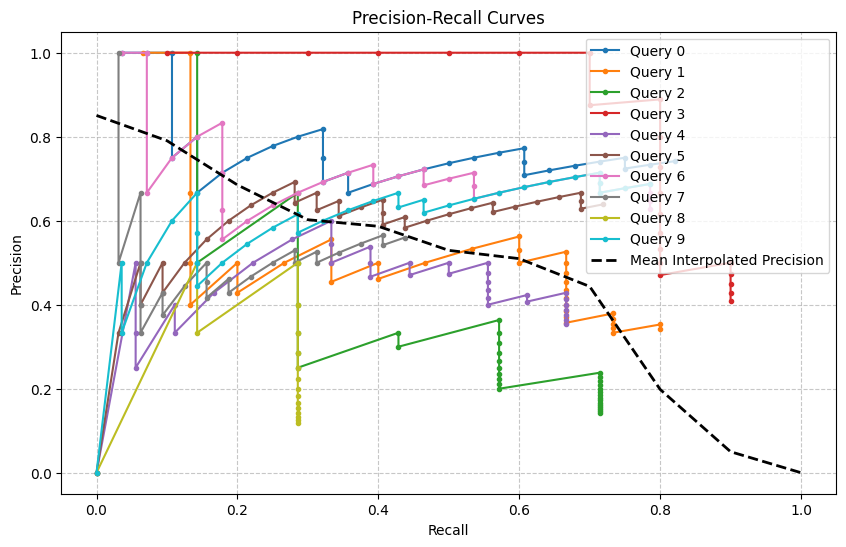

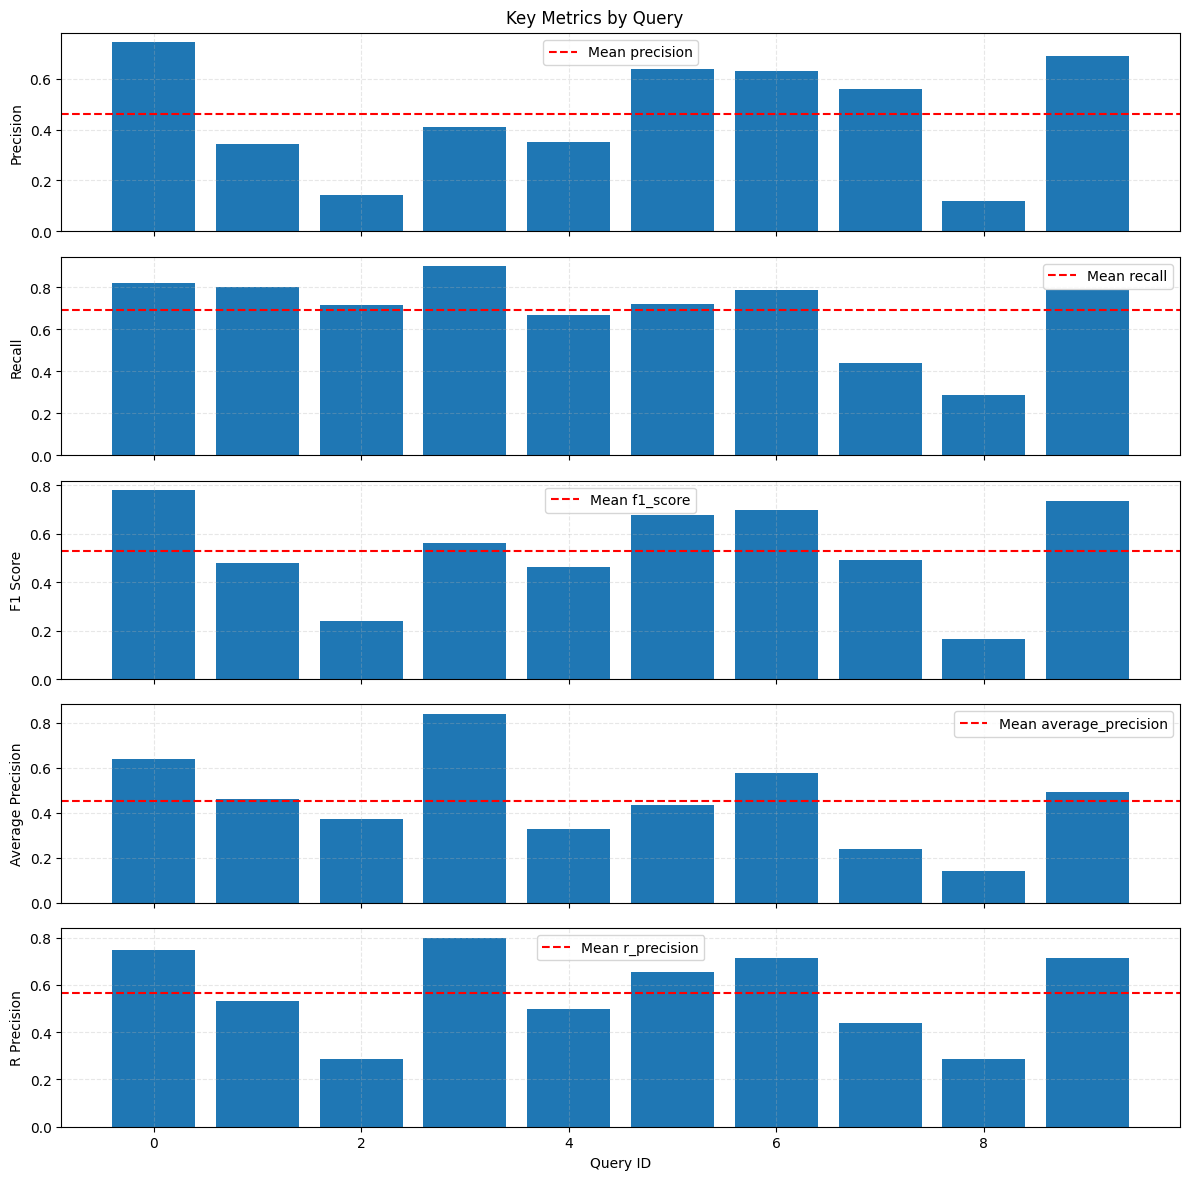

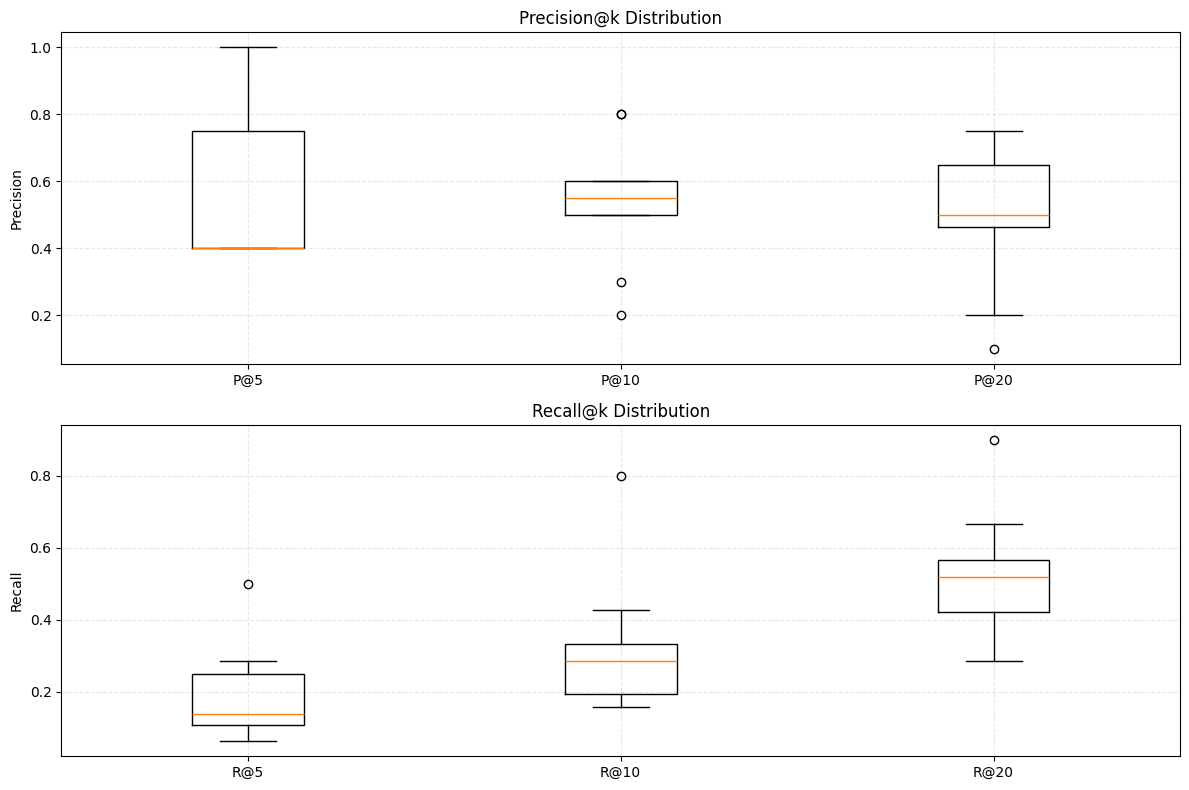

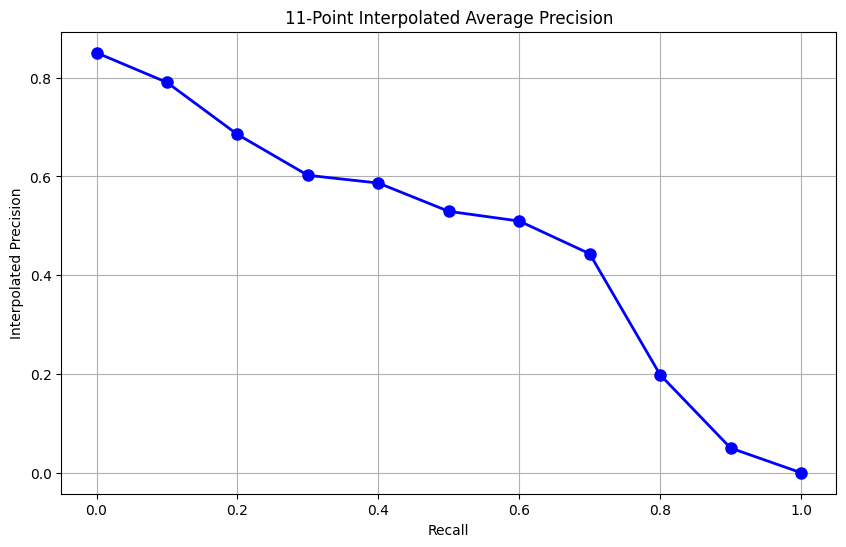

======= SUMMARY METRICS =======
Mean Precision: 0.4622
Mean Recall: 0.6916
Mean F1 Score: 0.5288
Mean Ap: 0.4525
Mean R Precision: 0.5677
Mean Precision@5: 0.5600
Mean Recall@5: 0.1834
Mean Precision@10: 0.5400
Mean Recall@10: 0.3203
Mean Precision@20: 0.5000
Mean Recall@20: 0.5198

Simulating user profile recommendations...

User ID: user01
----------------------------------------
Interests: travel, arts, nature, wildlife, culture
Search History:
  1. best places to visit in Europe
  2. wildlife photography tips
  3. contemporary art exhibitions
  4. natural landscapes photography
  5. cultural heritage sites


User ID: user02
----------------------------------------
Interests: technology, innovation, business, programming, entrepreneurship
Search History:
  1. emerging technology trends
  2. startup funding strategies
  3. technology innovation examples
  4. business development strategies
  5. tech company news


Generating recommendations for user01...
Top 5 recommendations for use

IndexError: index 2421 is out of bounds for axis 0 with size 379

In [114]:
def main():
    """
    Main function with improved evaluation methodology
    """
    # Set up base directory
    base_dir = 'bbc_articles'  # Update this path to your data directory

    # 1. Load and preprocess documents
    print("Loading and preprocessing documents...")
    documents, doc_paths = load_documents(base_dir)
    documents = preprocess_documents(documents)

    # 2. Build inverted index and calculate TF-IDF
    print("\nBuilding inverted index and calculating TF-IDF scores...")
    documents = calculate_term_frequencies(documents)
    inverted_index = build_inverted_index(documents)
    tfidf, doc_vectors = calculate_tfidf(documents, inverted_index)

    # Display inverted index
    display_inverted_index(inverted_index)

    # 3. Create diverse test queries and generate relevance judgments
    print("\nCreating test queries and relevance judgments...")
    test_queries = create_diverse_test_queries()
    test_queries = generate_relevance_judgments(test_queries, documents)

    # 4. Comprehensive evaluation
    print("\nPerforming comprehensive evaluation...")
    eval_results = comprehensive_evaluation(test_queries, documents, inverted_index, doc_vectors)

    # 5. Visualize evaluation results
    print("\nVisualizing evaluation results...")
    visualize_evaluation_results(eval_results)

    # 6. User profile recommendations
    print("\nSimulating user profile recommendations...")
    user_profiles = create_user_profiles()
    user_recommendations = simulate_user_recommendations(user_profiles, documents, inverted_index, doc_vectors)

    # 7. Evaluate user recommendations
    print("\nEvaluating user recommendations...")
    user_eval_results = evaluate_user_recommendations(user_recommendations, user_profiles, documents)

    # Display user evaluation results
    for user_id, metrics in user_eval_results.items():
        print(f"\nEvaluation for {user_id}:")
        print(f"Precision (category match): {metrics['precision']:.4f}")
        print(f"Average relevance score: {metrics['avg_relevance']:.4f}")

if __name__ == "__main__":
    main()

___

### Summary and Key Observations  

#### System Performance  
- Precision at **top ranks** was high, but **recall declined** at deeper levels.  
- **Mean Precision:** 46.22% | **Mean Recall:** 69.16% | **Mean MAP:** 45.25%  
- **Interpolated Precision curves** show strong early retrieval performance but lower effectiveness at high recall levels.  

#### User Recommendation Insights  

##### User01 (Arts & Travel)  
- Interests: Arts, Travel, Nature, Wildlife, Culture  
- **Top recommendations** were mostly Arts-focused, with some Travel articles.  
- **Precision:** 70% | **Avg. Relevance Score:** 0.51  
- **Findings:**  
  - The system accurately captured **arts-related interests** but underrepresented travel-related content.  

##### User02 (Tech & Innovation)  
- Interests: Technology, Innovation, Business  
- **Received mostly Innovation & Technology documents**, with minor overlap from Arts.  
- **Precision:** 90% | **Avg. Relevance Score:** 0.56  
- **Findings:**  
  - Strong alignment with **tech/business interests**, ranking relevant documents **higher**.  

#### What We Learned  
- **TF-IDF + Cosine Similarity performed well** for ranking relevant documents.  
- **Personalization significantly improved category precision**, especially for **User02 (90%)**.  
- User01’s Travel interests were **less represented**, suggesting **category imbalance**.  
- **Top-5 results were highly relevant**, but recall could improve using **query expansion** or **hybrid retrieval**.  

---

### So, What Did We Do?  
- Processed **60 BBC news articles**, built an **inverted index**, and ranked documents using **TF-IDF + Cosine Similarity**.  
- **Evaluated retrieval quality** using **Precision, Recall, F1 Score, MAP, and R-Precision**, along with **visualizations**.  
- **Personalized recommendations** for two users and analyzed retrieval effectiveness.  
- **Results showed strong precision**, but recall could be improved, especially for users with **multi-category interests**.  


___

### Appendix: Documents Used (Data Source - bbc_articles as PDFs)
1. Innovation

   1.1 **[Apple boss Tim Cook says DEI programmes may have to change](https://www.bbc.com/news/articles/clyjv8e49deo)** <br>
   1.2 **[Apple AI tool transcribed the word 'racist' as 'Trump'](https://www.bbc.com/news/articles/c5ymvjjqzmeo)** <br>
   1.3 **[Artists release silent album in protest against AI using their work](https://www.bbc.com/news/articles/cwyd3r62kp5o)** <br>
   1.4 **[Seven planets align in UK skies this week for last time until 2040](https://www.bbc.com/news/articles/c5yd4z15r54o)** <br>
   1.5 **[What Apple pulling UK Advanced Data Protection means for you](https://www.bbc.com/news/articles/cn524lx9445o)** <br>
   1.6 **[Cancer scans could be revolutionised by nuclear start-up](https://www.bbc.com/news/articles/c1kjmm3n427o)** <br>
   1.7 **[University of Surrey raises £70.3m to help disadvantaged students](https://www.bbc.com/news/articles/cgq90vv9zv5o)** <br>
   1.8 **[Mobile phone theft: What to do if your device is stolen](https://www.bbc.com/news/articles/cwygwnvdq23o)** <br>
   1.9 **[Women's abuse online: 'I get trolled every second, every day'](https://www.bbc.com/news/articles/c625z3xgyv1o)** <br>
   1.10 **[Singapore's biggest bank DBS to cut 4,000 roles as it embraces AI](https://www.bbc.com/news/articles/c4g7xn9y64po)** <br>
   1.11 **[Apple commits to 'largest ever' $500bn US investment](https://www.bbc.com/news/articles/ce980m2xv30o)** <br>
2. Arts

   2.1 **[Henry Orlik: £50k reward for return of art by surrealist recluse](https://www.bbc.com/news/articles/c5yen2k3l37o)** <br>
   2.2 **[Northampton theatre could close after budget cut, says councillor](https://www.bbc.com/news/articles/cn8rxpn3302o)** <br>
   2.3 **[Ukranian bombed door sculpture needs display sites, artist says](https://www.bbc.com/news/articles/c0q1w2ed4lqo)** <br>
   2.4 **[Wiltshire exhibition to display art by domestic abuse survivors](https://www.bbc.com/news/articles/c9vm4jrrp99o)** <br>
   2.5 **[Keith Flint mural in Braintree to be restored to former glory](https://www.bbc.com/news/articles/cn0j1j9rzneo)** <br>
   2.6 **[New roof to protect 'much-loved' Plowright Theatre in Scunthorpe](https://www.bbc.com/news/articles/cly4nnn9yzzo)** <br>
   2.7 **[Plan to remove Devon theatre sign causes controversy](https://www.bbc.com/news/articles/c86pwy84wxpo)** <br>
   2.8 **[Droitwich Spa: Rik Mayall mural unveiled in hometown](https://www.bbc.com/news/articles/c2erx2exk87o)** <br>
   2.9 **[Westminster visit to highlight Hull's culture strategy](https://www.bbc.com/news/articles/clyz2q5dq2eo)** <br>
   2.10 **[Consett Empire reduced hours 'protects venue'](https://www.bbc.com/news/articles/cz61l7pg3j8o)** <br>
3. Technology

   3.1 **[Apple AI tool transcribed the word 'racist' as 'Trump'](https://www.bbc.com/news/articles/c5ymvjjqzmeo)** <br>
   3.2 **[Wonder Woman game axed as Warner Bros cuts three studios](https://www.bbc.com/news/articles/c0q1w9q1qvyo)** <br>
   3.3 **[Technicolor: Historic visual effects studio collapses in UK](https://www.bbc.com/news/articles/c89yxk1egkgo)** <br>
   3.4 **[Virgin Media internet restored after earlier outage](https://www.bbc.com/news/articles/cy05n9xn1nqo)** <br>
   3.5 **[Medical trial helps paralysed Bedfordshire woman be a mum again](https://www.bbc.com/news/articles/ckg87l62ywjo)** <br>
   3.6 **[Apple pulls data protection tool after UK government security row](https://www.bbc.com/news/articles/cgj54eq4vejo)** <br>
   3.7 **[Coinbase boss claims SEC will drop crypto lawsuit](https://www.bbc.com/news/articles/cgm1g37p1z8o)** <br>
   3.8 **[Tesla shares slump after European sales fall](https://www.bbc.com/news/articles/cvgd9v3r69qo)** <br>
   3.9 **[What Apple pulling UK Advanced Data Protection means for you](https://www.bbc.com/news/articles/cn524lx9445o)** <br>
   3.10 **[Cancer scans could be revolutionised by nuclear start-up](https://www.bbc.com/news/articles/c1kjmm3n427o)** <br>
   3.11 **[University of Surrey raises £70.3m to help disadvantaged students](https://www.bbc.com/news/articles/cgq90vv9zv5o)** <br>
   3.12 **[Apple boss Tim Cook says DEI programmes may have to change](https://www.bbc.com/news/articles/clyjv8e49deo)** <br>
   3.13 **[How accurate are the viral TikTok AI POV lab history videos?](https://www.bbc.com/news/articles/cy87076pdw3o)** <br>
   3.14 **[Mobile phone theft: What to do if your device is stolen](https://www.bbc.com/news/articles/cwygwnvdq23o)** <br>
   3.15 **[Women's abuse online: 'I get trolled every second, every day'](https://www.bbc.com/news/articles/c625z3xgyv1o)** <br>
   3.16 **[Learning to code "will seriously change your life"](https://www.bbc.com/news/business-56194958)** <br>
4. Business

   4.1 **[Tesla shares slump after European sales fall](https://www.bbc.com/news/articles/cvgd9v3r69qo)** <br>
   4.2 **[India: A billion people have no real money to spend, says report](https://www.bbc.com/news/articles/c8rk5d7ekjmo)** <br>
   4.3 **[Trump orders probe of copper in first step to tariffs](https://www.bbc.com/news/articles/c5yxv0yj40ko)** <br>
   4.4 **[Kidney trade: Myanmar villagers fly to India to sell organs illegally](https://www.bbc.com/news/articles/ckgy8p3pe71o)** <br>
   4.5 **[Singapore's biggest bank DBS to cut 4,000 roles as it embraces AI](https://www.bbc.com/news/articles/c4g7xn9y64po)** <br>
   4.6 **[Theranos founder Elizabeth Holmes loses fraud appeal](https://www.bbc.com/news/articles/c1jpg0069wgo)** <br>
   4.7 **[Putin offers Russian and Ukrainian rare minerals to US](https://www.bbc.com/news/articles/c4gdx7488g5o)** <br>
   4.8 **[Apple AI tool transcribed the word 'racist' as 'Trump'](https://www.bbc.com/news/articles/c5ymvjjqzmeo)** <br>
   4.9 **[BP shuns renewables in return to oil and gas](https://www.bbc.com/news/articles/c3374ekd11po)** <br>
   4.10 **[US House narrowly passes Trump-backed spending bill](https://www.bbc.com/news/articles/cp9yx7e13ryo)** <br>
   4.11 **[Wonder Woman game axed as Warner Bros cuts three studios](https://www.bbc.com/news/articles/c0q1w9q1qvyo)** <br>
   4.12 **[Ukraine PM says minerals deal agreed with US](https://www.bbc.com/news/articles/c337461n3xlo)** <br>
   4.13 **[Who is Doge's official leader? White House won't say it's Musk](https://www.bbc.com/news/articles/c2erg38vjx8o)** <br>
   4.14 **[Countries compete to keep skilled young workers](https://www.bbc.com/news/articles/cj30xr1vy2lo)** <br>
   4.15 **[Apple boss Tim Cook says DEI programmes may have to change](https://www.bbc.com/news/articles/clyjv8e49deo)** <br>
5. Travel

   5.1 **[Ridge Hill grass landing strip planning exemption refused](https://www.bbc.com/news/articles/cy83x20l3nzo)** <br>
   5.2 **[Dead body placed beside Australian couple on Qatar Airways flight](https://www.bbc.com/news/articles/cz03l18jv97o)** <br>
   5.3 **[London: St James's Palace to open to the public for first time](https://www.bbc.com/news/articles/c62z77edl33o)** <br>
   5.4 **[Isle of Man to introduce digital travel permit in late 2025](https://www.bbc.com/news/articles/cq6y4en6przo)** <br>
   5.5 **[New career at 50 for trainee EasyJet cabin crew](https://www.bbc.com/news/articles/cx2gyrvl55lo)** <br>
   5.6 **[Park warning after escaped python sightings](https://www.bbc.com/news/articles/cx2lmnl2gdvo)** <br>
   5.7 **[Royal python found abandoned outside block of flats](https://www.bbc.com/news/articles/czx8qxdqr75o)** <br>


### ___ END ___